<a href="https://colab.research.google.com/github/TrudyCyns/telemetry-anomaly-detection/blob/main/telemetry_anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install Kaggle API
!pip install kaggle

# Upload Kaggle API key (download kaggle.json from your Kaggle account)
from google.colab import files
files.upload()   # select kaggle.json

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Create storage folders for data
!mkdir -p /content/data/skab

Saving kaggle.json to kaggle.json


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yuriykatser/skoltech-anomaly-benchmark-skab")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/yuriykatser/skoltech-anomaly-benchmark-skab/versions/1


In [ ]:
# Unzip Dataset
!unzip -q "/content/skoltech-anomaly-benchmark-skab.zip" -d "/content/data/skab"

WORKING CODE

In [ ]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

In [ ]:
# Load Data

df = pd.read_csv("/content/data/skab/SKAB/valve1/0.csv", delimiter=';')  # adjust path if using NAB

df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values("datetime")

print(df.head())


             datetime  Accelerometer1RMS  Accelerometer2RMS  Current  \
0 2020-03-09 10:14:33           0.026588           0.040111  1.33020   
1 2020-03-09 10:14:34           0.026170           0.040452  1.35399   
2 2020-03-09 10:14:35           0.026199           0.039419  1.54006   
3 2020-03-09 10:14:36           0.026027           0.039641  1.33458   
4 2020-03-09 10:14:37           0.026290           0.040273  1.07851   

   Pressure  Temperature  Thermocouple  Voltage  Volume Flow RateRMS  anomaly  \
0  0.054711      79.3366       26.0199  233.062                 32.0      0.0   
1  0.382638      79.5158       26.0258  236.040                 32.0      0.0   
2  0.710565      79.3756       26.0265  251.380                 32.0      0.0   
3  0.382638      79.6097       26.0393  234.392                 32.0      0.0   
4 -0.273216      79.6109       26.0420  225.342                 32.0      0.0   

   changepoint  
0          0.0  
1          0.0  
2          0.0  
3          0

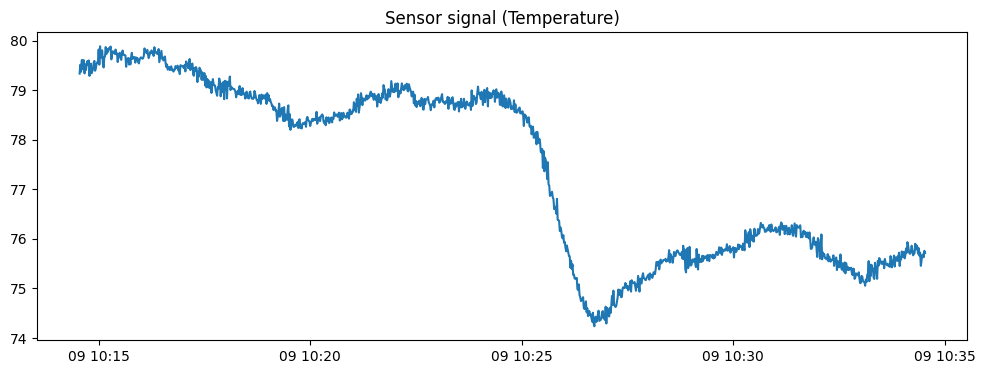

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(df['datetime'], df['Temperature'])
plt.title("Sensor signal (Temperature)")
plt.show()

FEATURE ENGINEERING + ISOLATION FOREST

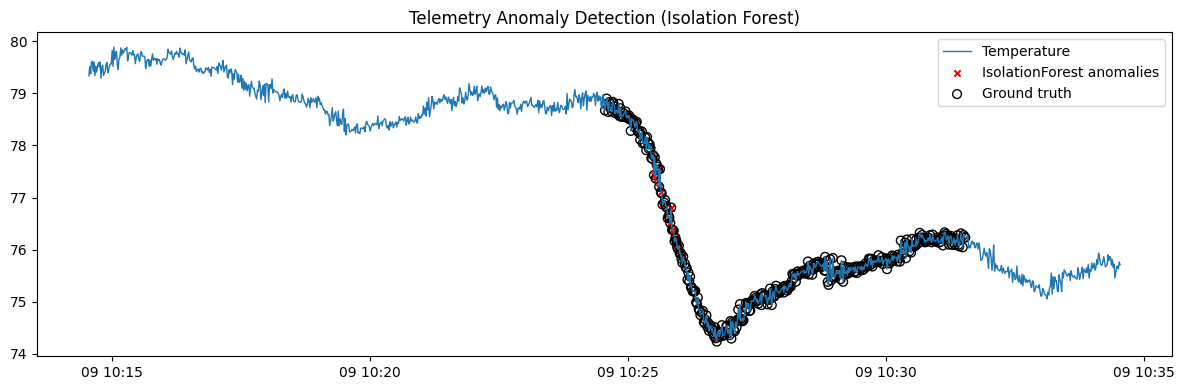

In [ ]:
# --- 1. Choose one telemetry-like channel (e.g. Temperature) ---
t = df["datetime"]
y = df["Temperature"].astype(float)

# --- 2. Simple rolling-window features ---
win = 30  # window size in samples
feat = pd.DataFrame({
    "val": y,
    "roll_mean": y.rolling(win, min_periods=1).mean(),
    "roll_std": y.rolling(win, min_periods=1).std().fillna(0),
    "diff": y.diff().fillna(0)
}).fillna(0)

# --- 3. Train Isolation Forest ---
clf = IsolationForest(
    n_estimators=200,
    contamination=0.02,   # ~2% anomalies
    random_state=42
)
clf.fit(feat)
scores = -clf.decision_function(feat)   # higher = more anomalous
threshold = np.percentile(scores, 98)   # top 2% as anomalies
pred = (scores >= threshold).astype(int)

# --- 4. Plot signal with anomalies overlaid ---
plt.figure(figsize=(12,4))
plt.plot(t, y, lw=1, label="Temperature")
plt.scatter(t[pred==1], y[pred==1], color="red", s=20, marker="x", label="IsolationForest anomalies")

# if ground truth labels exist in SKAB (column 'anomaly'):
if "anomaly" in df.columns:
    truth = df["anomaly"]==1
    plt.scatter(t[truth], y[truth], facecolors="none", edgecolors="k",
                s=40, label="Ground truth")

plt.title("Telemetry Anomaly Detection (Isolation Forest)")
plt.legend()
plt.tight_layout()
plt.savefig("anomaly_iforest.png", dpi=150)
plt.show()

CLASSICAL v. ML

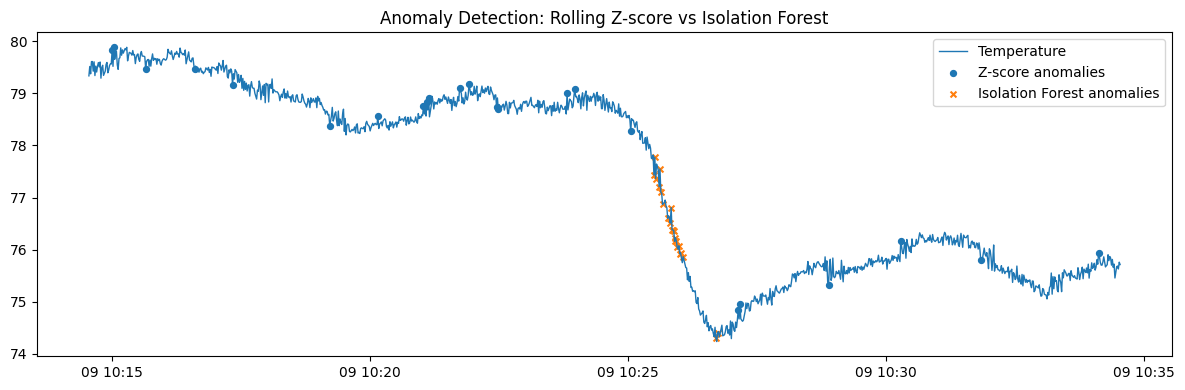

Isolation Forest  — Precision: 1.000 | Recall: 0.057
Z-score baseline  — Precision: 0.217 | Recall: 0.012


In [ ]:
from sklearn.metrics import precision_score, recall_score

# --- Assumes you already have: df with 'datetime' + 'Temperature'
# --- and Isolation Forest outputs: `pred` (0/1), `t`, `y` from the previous cell

# 1) Rolling z-score baseline
win = 30  # keep same window as IF features for fairness
mu = y.rolling(win, min_periods=1).mean()
sigma = y.rolling(win, min_periods=1).std().replace(0, np.nan)
z = ((y - mu) / sigma).abs().fillna(0)

# threshold: match IF's "top 2%" idea
z_th = np.percentile(z, 98)
z_pred = (z >= z_th).astype(int)

# 2) Combined plot (classical vs ML)
plt.figure(figsize=(12,4))
plt.plot(t, y, lw=1, label="Temperature")
plt.scatter(t[z_pred==1], y[z_pred==1], s=18, marker="o", label="Z-score anomalies")
plt.scatter(t[pred==1],   y[pred==1],   s=18, marker="x", label="Isolation Forest anomalies")
plt.title("Anomaly Detection: Rolling Z-score vs Isolation Forest")
plt.legend()
plt.tight_layout()
plt.savefig("compare_iforest_zscore.png", dpi=150)
plt.show()

# 3) Quick metrics if ground truth exists (SKAB has 'anomaly' column)
if "anomaly" in df.columns:
    y_true = (df["anomaly"] == 1).astype(int)
    p_if = precision_score(y_true, pred, zero_division=0)
    r_if = recall_score(y_true, pred, zero_division=0)
    p_z  = precision_score(y_true, z_pred, zero_division=0)
    r_z  = recall_score(y_true, z_pred, zero_division=0)
    print(f"Isolation Forest  — Precision: {p_if:.3f} | Recall: {r_if:.3f}")
    print(f"Z-score baseline  — Precision: {p_z:.3f} | Recall: {r_z:.3f}")
